In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
data = pd.read_csv('../data/2016-08-08-last-year.xz',
                   parse_dates=[16],
                   dtype={'document_id': np.str,
                          'congressperson_id': np.str,
                          'congressperson_document': np.str,
                          'term_id': np.str,
                          'cnpj_cpf': np.str,
                          'reimbursement_number': np.str})

# Data preparation

In [3]:
meals = data[data.subquota_description == 'Congressperson meal']

In [4]:
meals.net_value.describe()

count    33540.000000
mean        63.384398
std        111.431368
min          0.000000
25%         24.430000
50%         47.630000
75%         77.220000
max       6205.000000
Name: net_value, dtype: float64

<IPython.core.display.Javascript object>


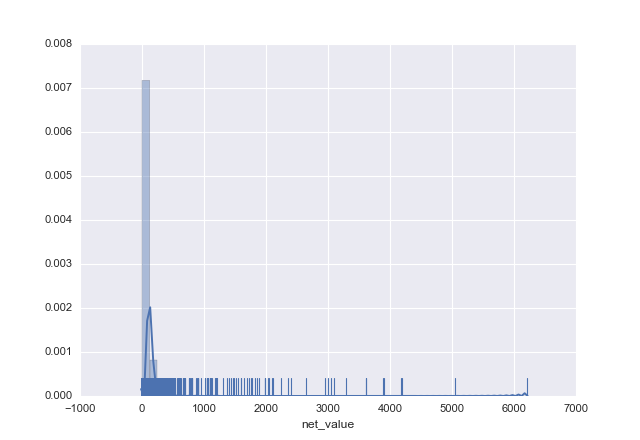

C:\Users\Tales\Anaconda3\envs\serenata\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


In [5]:
plt.figure()
sns.distplot(meals.net_value, rug=True);

In [6]:
grouped = meals.groupby('cnpj_cpf', as_index=False)

print('{} total cnpj/cpfs, {} are unique'.format(len(meals), len(grouped)))

33540 total cnpj/cpfs, 5926 are unique


## Creating a dataframe with the first supplier name for each cnpj_cpf:

In [7]:
cnpj_cpfs = []
names = []
for group in grouped:
    cnpj_cpfs.append(group[0])
    names.append(group[1].iloc[0].supplier)

names = pd.DataFrame({'cnpj_cpf': cnpj_cpfs, 'supplier_name': names})
names.head()

,cnpj_cpf,supplier_name
0,00006453000125,RIPA NA BRASA
1,00009332000137,SORVETERIA E CONFEITARIA DOM BOSCO LTDA
2,00015014000189,Mercado Natural Ltda.
3,00015228000155,Polipan Paes e Doces LTDA
4,00015327000137,YELLOW - COMIDA CASEIRA E PIZZARIA LTDA. - ME


# CNPJs/CPFs that received most payments

The first issue with the dataset is that some places have more than one CNPJ, like SENAC.

In [8]:
spent = grouped.agg({'net_value': np.nansum}).sort_values(by='net_value', ascending=False)

spent = pd.merge(spent, names, on='cnpj_cpf')
spent.head(10)

,cnpj_cpf,net_value,supplier_name
0,33469172001644,213954.61,SENAC - SERVIÇO NACIONAL DE APRENDIZAGEM COMER...
1,33469172000672,105660.41,SENAC - serviço de Nacional de aprendizagem co...
2,10580005000356,95896.16,CENTRAL PARK RESTAURANTE E EVENTOS LTDA ME
3,09054158000119,35478.03,PBJM COMERCIO DE GENEROS ALIMENTICIOS LTDA
4,10542662000147,28653.09,COCO BAMBU LAGO SUL COMERCIO DE ALIMENTOS LTDA.
5,16955896000445,24753.64,BARU RESTAURANTE LTDA.
6,11903789000107,22384.06,COCO BAMBU BRASÍLIA COMÉRCIO DE ALIMENTOS LTDA
7,03327191000199,19794.89,DOM FRANCISCO RESTAURANTE LTDA.
8,09109567001732,18621.63,GOLDEN TULIP BRASILIA ALVORADA
9,14883329000152,18553.78,BAR E RESTAURANTE DO ALEMÃO DE BRASÍLIA LTDA


<IPython.core.display.Javascript object>


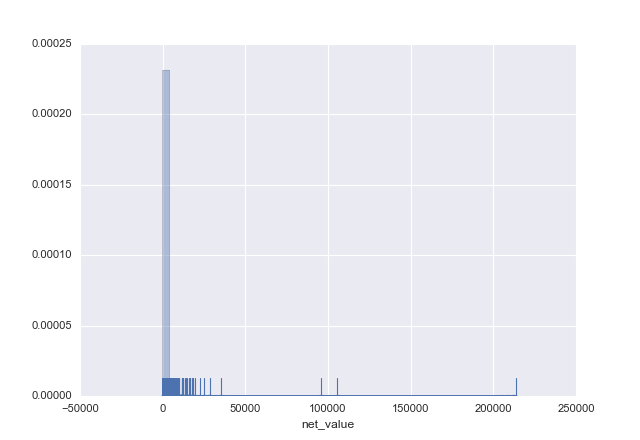

C:\Users\Tales\Anaconda3\envs\serenata\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


In [9]:
plt.figure()
sns.distplot(spent['net_value'], rug=True);

# CNPJs/CPFs that received most visits

In [10]:
visits = grouped['cnpj_cpf'].agg({'visits': len}).sort_values(by='visits', ascending=False)
visits = pd.merge(visits, names, on='cnpj_cpf')
visits.head(10)

,cnpj_cpf,visits,supplier_name
0,33469172001644,4520,SENAC - SERVIÇO NACIONAL DE APRENDIZAGEM COMER...
1,33469172000672,4402,SENAC - serviço de Nacional de aprendizagem co...
2,10580005000356,1085,CENTRAL PARK RESTAURANTE E EVENTOS LTDA ME
3,16955896000445,591,BARU RESTAURANTE LTDA.
4,09054158000119,332,PBJM COMERCIO DE GENEROS ALIMENTICIOS LTDA
5,33469172002292,294,SERVICO NACIONAL DE APRENDIZ. COM.SENAC
6,00679365000194,206,ASSOCIAÇÃO DOS SERVIDORES DA CÂMARA DOS DEPUTADOS
7,11903789000107,200,COCO BAMBU BRASÍLIA COMÉRCIO DE ALIMENTOS LTDA
8,10542662000147,187,COCO BAMBU LAGO SUL COMERCIO DE ALIMENTOS LTDA.
9,06098111000169,170,Restaurante Nippon


<IPython.core.display.Javascript object>


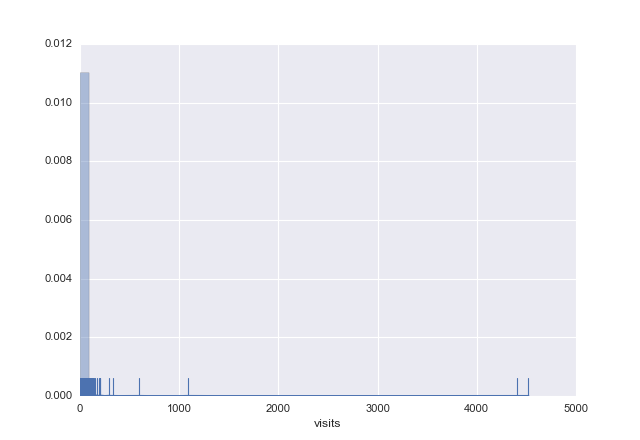

C:\Users\Tales\Anaconda3\envs\serenata\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


In [11]:
plt.figure()
sns.distplot(visits['visits'], rug=True);

# Combining the two previous dataframes to have an average spent value per visit:

We can identify places that were less frequented but charged high values. That shows some strange values such as R$ 4200 spent on just one visit in a place that looks like a car selling store (according to its name).

In [12]:
spent_visit = pd.merge(spent, visits, on=['cnpj_cpf', 'supplier_name'])

spent_visit.loc[:,'average_net_value'] = spent_visit.net_value/spent_visit.visits

spent_visit.sort_values(by='average_net_value', ascending=False, inplace=True)
spent_visit.head(20)

,cnpj_cpf,net_value,supplier_name,visits,average_net_value
58,04780541000130,4200.00,VR COMERCIO DE VEICULOS LTDA-ME,1,4200.000000
60,14922838000147,3900.00,Elizangela tatiana Kinoshita Martini ME,1,3900.000000
128,06033429000161,2050.00,PRIME BUREAU DE NEGOCIOS LTDA,1,2050.000000
66,08983342000180,3680.00,LA PENHA - GABRIELA BURFFET LTDA.-ME,2,1840.000000
35,10544267000101,7244.90,Celebrate - Serviços de Catering e Eventos Ltda,5,1448.980000
13,09612226000118,15727.20,MANGER COMERCIO DE ALIMENTOS LTDA,17,925.129412
8,09109567001732,18621.63,GOLDEN TULIP BRASILIA ALVORADA,37,503.287297
515,08532429000131,500.00,AMORETTO CAFÉS EXPRESSO LTDA,1,500.000000
173,02484060000152,1497.80,LOPES OLIVEIRA COMÉRCIO DE ALIMENTOS LTDA -EPP,3,499.266667
534,08345314000138,484.75,ROTA DO CHARME DOCES FINOS DE PELOTAS LTDA,1,484.750000


This first part reveal some places that are almost never visited and have high values spent on. There are also places with some visits and high average value. For the less frequented places, there's not enough data to take an average value, but an overall average price for the entire dataset may be useful to highlight these cases.

In [13]:
meals.net_value.describe()

count    33540.000000
mean        63.384398
std        111.431368
min          0.000000
25%         24.430000
50%         47.630000
75%         77.220000
max       6205.000000
Name: net_value, dtype: float64

From above, we see that the average value is **R\$ 63** and median value with a huge standard deviation of **R\$ 111**. The median value is **R\$ 47**.

An issue that bias the mean of the dataset is the existence of meals paid for groups.

# Fitting a linear regression to the relation net_value x visits. It is expected that more visits means greater accumulated net_value:

Here's a rather naïve assumption: the more a place is visited, the more money is spent in there. This is obviously not true since there are great differences in prices depending on which place is visited, but it turns out that a linear model wasn't too bad, but I think other models should be tested and compared later. From this part, the points that are too far **below** the line in the picture could be better investigated because they are too expensive (they get more money with less visits).

<IPython.core.display.Javascript object>


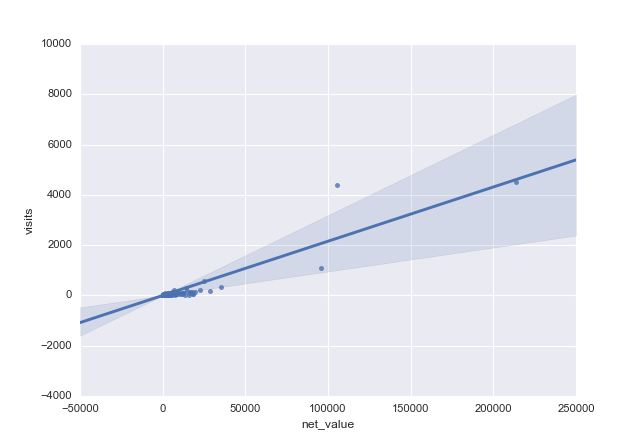

In [14]:
plt.figure()
sns.regplot(x="net_value", y="visits", data=spent_visit);

# Analysis by CNPJ

Now the analysis uses only expenses of single places (notice that there the two SENAC instances should be merged for a proper anaylis, but it wasn't done in this case). For that, I've used the [Outlier Labeling Rule](http://www.itl.nist.gov/div898/handbook/eda/section3/eda35h.htm), that uses the median instead of the mean, a measure that is more robust to outliers. The authors of this method recommend that any modified z-score greater than 3.5 should be considered as a potential outlier if the data is expected to come from a normal distribution. What follows is the application of this method for the first 10 most visited places, as it's not very helpful to make this to places less frequented.

In [15]:
from statsmodels.robust.scale import mad

# modified z-score
def modified_z_score(x):
    return (0.6745 * (x - np.median(x))) / mad(x)

In [16]:
#Analyzing the top10 most visited
for row in visits[:10].itertuples():
    print(row.cnpj_cpf, row.supplier_name)
    
    supplier_meals = meals[meals.cnpj_cpf == row.cnpj_cpf]
    print('{} meals'.format(len(supplier_meals)))
    
    mean = np.mean(supplier_meals.net_value)
    print('mean value = R$ {:.2f}'.format(mean))
    
    std = np.std(supplier_meals.net_value)
    print('standard deviation = R$ {:.2f}'.format(std))
    
    median = np.median(supplier_meals.net_value)
    print('median value = R$ {:.2f}'.format(median))
    
    modified_zscores = modified_z_score(supplier_meals.net_value)
    outlier_indexes = [i for i, score in enumerate(modified_zscores) if score > 3.5]
    
    print('{} outliers'.format(len(outlier_indexes)))
    print(supplier_meals.iloc[outlier_indexes][['document_id', 'net_value']])
    
    print()

33469172001644 SENAC - SERVIÇO NACIONAL DE APRENDIZAGEM COMERCIAL
4520 meals
mean value = R$ 47.34
standard deviation = R$ 28.94
median value = R$ 50.53
64 outliers
       document_id  net_value
598        5782202     105.46
7588       5588057      79.50
9932       5803005      67.73
16346      5623391      97.76
30604      5792872      98.76
44220      5785369      95.26
44221      5785360      95.26
52357      5636479     104.26
57727      5628022     103.76
57736      5766956      98.16
61982      5644130     151.89
63360      5657139     100.26
64000      5780651     104.46
64009      5825001      67.71
69203      5765985      78.00
70426      5640047     150.89
80779      5689496     102.26
113153     5776963      97.40
113154     5683325      69.50
118429     5658001      68.76
138588     5733343      95.26
143537     5775759     103.96
151281     5650595      97.76
154903     5867989     103.96
156367     5829580     106.06
159387     5611882      86.50
168050     5794364      9